In [1]:
#For timing stuff
import time
globalstart = time.time()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#For random forest for time series:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

#For metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#For multiprocessing further down
import multiprocessing
import ray
from joblib import parallel_backend
from ray.util.joblib import register_ray
register_ray()

In [2]:
ray.init(address="auto")
num_cores = multiprocessing.cpu_count()
print(num_cores)

num_cores = 100 #incase it can only see the cores on the host node

2023-01-29 09:20:37,132	INFO worker.py:1352 -- Connecting to existing Ray cluster at address: n-62-31-7:24789...


[2023-01-29 09:20:37,152 I 97088 97088] global_state_accessor.cc:357: This node has an IP address of 10.66.31.7, while we can not find the matched Raylet address. This maybe come from when you connect the Ray cluster with a different IP address or connect a container.
2023-01-29 09:20:37,156	INFO worker.py:1529 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:50435 


24


In [3]:
def loadSeries(datatype=None,house=None,rename=None):
    '''
    Loading data series from cf_filled (consumption) or pf_filled (production)
    
    datatype: str, specifies whether the production or consumption values are selected
              
              "Production", "Consumption", "P", "C", "prod", "cons", etc.
    
    
    house: str, specifies which house is selected 
           
           "k28", "h16", "h22", "h28", or "h32"
         
    rename: str, renames chosen column. 
            
            If the whole file is returned, this parameter is ignored
    '''
    res = None
    #Production or consumption string stuff
    datatypeStr = ""
    if datatype is None:
        raise Exception("First input must specify either Production or Consumption")
    elif datatype[0].lower()=="p":
        datatypeStr = "prod_"
    elif datatype[0].lower()=="c":
        datatypeStr = "cons_"
    
    #Making sure an existing house is chosen
    if house is None:
        raise Exception("Second input must specify house: k28, h16, h22, h28, or h32")
    elif house.lower() not in ["k28","h16","h22","h28","h32"]:
        raise Exception("Second input must specify house: k28, h16, h22, h28, or h32")
    
    #Production or consumption is chosen and loaded
    if datatypeStr=="prod_":
        res = pd.read_csv("pf_filled.csv",sep=",")
        res = res[["Time",datatypeStr+house]]
        res["Time"] = pd.to_datetime(res["Time"], utc=True)
        res = res.set_index("Time").sort_index()
        res.index = pd.date_range(start=res.index[0], end=res.index[-1], freq="h")
    else:
        res = pd.read_csv("cf_filled.csv",sep=",")
        res["Time"] = pd.to_datetime(res["Time"], utc=True)
        res = res.set_index("Time").sort_index()
        res.index = pd.date_range(start=res.index[0], end=res.index[-1], freq="h")
    
    #Renaming value column
    if not house is None and not rename is None:
        res = res.rename(columns={datatypeStr+house: rename}, errors="raise")
    
    #Nice stuff for indexing
    res['year']=res.index.year
    res['month']=res.index.month
    #res['week']=res.index.week is deprecated and no longer works properly
    res['weekday']=res.index.weekday
    res['hour']=res.index.hour
    return res

def moving_average(timeseries, window):
    return timeseries.rolling(window=window, center=True).mean()

                           val  year  month  weekday  hour
2020-12-22 00:00:00+00:00  0.0  2020     12        1     0
2020-12-22 01:00:00+00:00  0.0  2020     12        1     1
2020-12-22 02:00:00+00:00  0.0  2020     12        1     2
2020-12-22 03:00:00+00:00  0.0  2020     12        1     3
2020-12-22 04:00:00+00:00  0.0  2020     12        1     4
...                        ...   ...    ...      ...   ...
2020-12-25 23:00:00+00:00  0.0  2020     12        4    23
2020-12-26 00:00:00+00:00  0.0  2020     12        5     0
2020-12-26 01:00:00+00:00  0.0  2020     12        5     1
2020-12-26 02:00:00+00:00  0.0  2020     12        5     2
2020-12-26 03:00:00+00:00  0.0  2020     12        5     3

[100 rows x 5 columns]


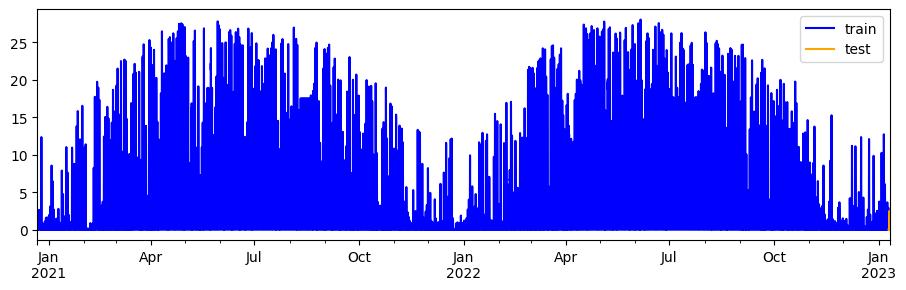

In [4]:
train_series = loadSeries("p","h16","val")
units_to_forecast = 24

print(train_series.head(100))

train = train_series[:-units_to_forecast]
test = train_series[-units_to_forecast:]

fig, ax=plt.subplots(figsize=(11, 3))
moving_average(train['val'], 3).plot(ax=ax, label='train', color='blue')
moving_average(test['val'], 1).plot(ax=ax, label='test', color='orange')
ax.legend();

## Short test forcast

2023-01-29 09:20:38,665	WARNING pool.py:593 -- The 'context' argument is not supported using ray. Please refer to the documentation for how to control ray initialization.


2023-01-29 09:20:42,624	WARNING worker.py:1851 -- WARNING: 16 PYTHON worker processes have been started on node: e27adcfbef62c7e0bb548f22badaf74f81be3c7e577a8e68bb9d2707 with address: 10.66.31.13. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


2023-01-29 09:20:43,958	WARNING worker.py:1851 -- WARNING: 21 PYTHON worker processes have been started on node: e27adcfbef62c7e0bb548f22badaf74f81be3c7e577a8e68bb9d2707 with address: 10.66.31.13. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


2023-01-29 09:20:43,965	WARNING worker.py:1851 -- WARNING: 24 PYTHON worker processes have been started on node: e27adcfbef62c7e0bb548f22badaf74f81be3c7e577a8e68bb9d2707 with address: 10.66.31.13. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


2023-01-29 09:20:45,277	WARNING worker.py:1851 -- WARNING: 28 PYTHON worker processes have been started on node: e27adcfbef62c7e0bb548f22badaf74f81be3c7e577a8e68bb9d2707 with address: 10.66.31.13. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


Test error (mse): 0.03080508333230995


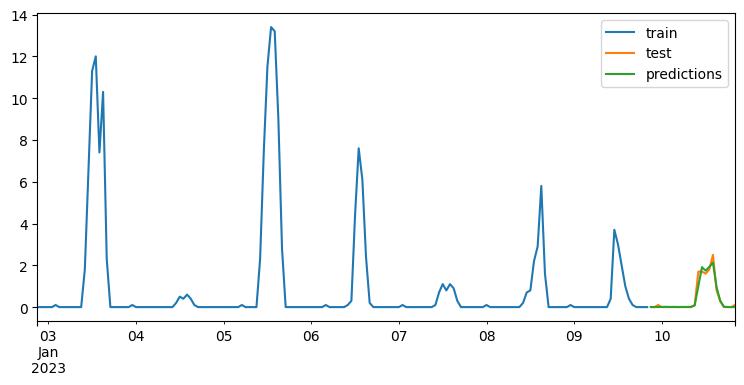

In [5]:
with parallel_backend('ray'):
    forecaster = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123, n_jobs=num_cores),
                    lags = 24
                    )

    forecaster.fit(y=train['val'])
    forecaster

    predictions = forecaster.predict(steps=units_to_forecast)

    predictions.index = test.index

    actual = train[-7*24:]

    fig, ax = plt.subplots(figsize=(9, 4))
    actual['val'].plot(ax=ax, label='train')
    test['val'].plot(ax=ax, label='test')
    predictions.plot(ax=ax, label='predictions')
    ax.legend();
    error_mse = mean_squared_error(
                    y_true = test['val'],
                    y_pred = predictions
                )

print(f"Test error (mse): {error_mse}")

## Hyperparameter tuning

In [6]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123, n_jobs=num_cores),
                lags      = 1 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [1, 2, 3, 12, 24]

# Regressor's hyperparameters
param_grid = {'n_estimators': [i for i in range(50,100,10)],
              'max_depth': [i for i in range(3,10,1)]}
start = time.time()
results_grid = grid_search_forecaster(
                            forecaster         = forecaster,
                            y                  = train_series[:]['val'],
                            param_grid         = param_grid,
                            lags_grid          = lags_grid,
                            steps              = units_to_forecast,
                            refit              = False,
                            metric             = 'mean_squared_error',
                            initial_train_size = int(len(train)),
                            return_best        = True,
                            fixed_train_size   = True,
                            verbose            = False
                   )
end = time.time()
print("Searching took {}s".format(end-start))
results_grid

Number of models compared: 175


loop lags_grid:   0%|                                               | 0/5 [00:00<?, ?it/s]

loop param_grid:   0%|                                             | 0/35 [00:00<?, ?it/s]

loop param_grid:   3%|█                                    | 1/35 [00:01<00:35,  1.05s/it]

loop param_grid:   6%|██                                   | 2/35 [00:02<00:41,  1.26s/it]

loop param_grid:   9%|███▏                                 | 3/35 [00:03<00:43,  1.37s/it]

loop param_grid:  11%|████▏                                | 4/35 [00:05<00:44,  1.45s/it]

loop param_grid:  14%|█████▎                               | 5/35 [00:07<00:47,  1.58s/it]

loop param_grid:  17%|██████▎                              | 6/35 [00:08<00:41,  1.43s/it]

loop param_grid:  20%|███████▍                             | 7/35 [00:09<00:38,  1.38s/it]

loop param_grid:  23%|████████▍                            | 8/35 [00:11<00:38,  1.44s/it]

loop param_grid:  26%|█████████▌                           | 9/35 [00:12<00:39,  1.50s/it]

loop param_grid:  29%|██████████▎                         | 10/35 [00:14<00:40,  1.61s/it]

loop param_grid:  31%|███████████▎                        | 11/35 [00:15<00:34,  1.46s/it]

loop param_grid:  34%|████████████▎                       | 12/35 [00:17<00:31,  1.39s/it]

loop param_grid:  37%|█████████████▎                      | 13/35 [00:18<00:31,  1.44s/it]

loop param_grid:  40%|██████████████▍                     | 14/35 [00:20<00:31,  1.49s/it]

loop param_grid:  43%|███████████████▍                    | 15/35 [00:22<00:31,  1.60s/it]

loop param_grid:  46%|████████████████▍                   | 16/35 [00:23<00:27,  1.46s/it]

loop param_grid:  49%|█████████████████▍                  | 17/35 [00:24<00:25,  1.42s/it]

loop param_grid:  51%|██████████████████▌                 | 18/35 [00:26<00:24,  1.43s/it]

loop param_grid:  54%|███████████████████▌                | 19/35 [00:27<00:24,  1.52s/it]

loop param_grid:  57%|████████████████████▌               | 20/35 [00:29<00:24,  1.62s/it]

loop param_grid:  60%|█████████████████████▌              | 21/35 [00:30<00:21,  1.51s/it]

loop param_grid:  63%|██████████████████████▋             | 22/35 [00:32<00:18,  1.46s/it]

loop param_grid:  66%|███████████████████████▋            | 23/35 [00:33<00:17,  1.47s/it]

loop param_grid:  69%|████████████████████████▋           | 24/35 [00:35<00:17,  1.56s/it]

loop param_grid:  71%|█████████████████████████▋          | 25/35 [00:37<00:16,  1.61s/it]

loop param_grid:  74%|██████████████████████████▋         | 26/35 [00:38<00:13,  1.52s/it]

loop param_grid:  77%|███████████████████████████▊        | 27/35 [00:39<00:11,  1.44s/it]

loop param_grid:  80%|████████████████████████████▊       | 28/35 [00:41<00:10,  1.45s/it]

loop param_grid:  83%|█████████████████████████████▊      | 29/35 [00:43<00:09,  1.54s/it]

loop param_grid:  86%|██████████████████████████████▊     | 30/35 [00:44<00:08,  1.61s/it]

loop param_grid:  89%|███████████████████████████████▉    | 31/35 [00:45<00:05,  1.47s/it]

loop param_grid:  91%|████████████████████████████████▉   | 32/35 [00:47<00:04,  1.45s/it]

loop param_grid:  94%|█████████████████████████████████▉  | 33/35 [00:48<00:02,  1.47s/it]

loop param_grid:  97%|██████████████████████████████████▉ | 34/35 [00:50<00:01,  1.55s/it]

loop param_grid: 100%|████████████████████████████████████| 35/35 [00:52<00:00,  1.61s/it]

loop lags_grid:  20%|███████▊                               | 1/5 [00:52<03:29, 52.39s/it]

loop param_grid:   0%|                                             | 0/35 [00:00<?, ?it/s]

loop param_grid:   3%|█                                    | 1/35 [00:01<00:38,  1.14s/it]

loop param_grid:   6%|██                                   | 2/35 [00:02<00:42,  1.29s/it]

loop param_grid:   9%|███▏                                 | 3/35 [00:03<00:43,  1.37s/it]

loop param_grid:  11%|████▏                                | 4/35 [00:05<00:45,  1.48s/it]

loop param_grid:  14%|█████▎                               | 5/35 [00:07<00:47,  1.58s/it]

loop param_grid:  17%|██████▎                              | 6/35 [00:08<00:41,  1.44s/it]

loop param_grid:  20%|███████▍                             | 7/35 [00:09<00:39,  1.42s/it]

loop param_grid:  23%|████████▍                            | 8/35 [00:11<00:38,  1.43s/it]

loop param_grid:  26%|█████████▌                           | 9/35 [00:13<00:39,  1.53s/it]

loop param_grid:  29%|██████████▎                         | 10/35 [00:14<00:39,  1.59s/it]

loop param_grid:  31%|███████████▎                        | 11/35 [00:15<00:34,  1.44s/it]

loop param_grid:  34%|████████████▎                       | 12/35 [00:17<00:32,  1.43s/it]

loop param_grid:  37%|█████████████▎                      | 13/35 [00:18<00:31,  1.42s/it]

loop param_grid:  40%|██████████████▍                     | 14/35 [00:20<00:30,  1.47s/it]

loop param_grid:  43%|███████████████▍                    | 15/35 [00:22<00:32,  1.61s/it]

loop param_grid:  46%|████████████████▍                   | 16/35 [00:23<00:27,  1.47s/it]

loop param_grid:  49%|█████████████████▍                  | 17/35 [00:24<00:25,  1.41s/it]

loop param_grid:  51%|██████████████████▌                 | 18/35 [00:26<00:24,  1.46s/it]

loop param_grid:  54%|███████████████████▌                | 19/35 [00:27<00:24,  1.51s/it]

loop param_grid:  57%|████████████████████▌               | 20/35 [00:29<00:24,  1.62s/it]

loop param_grid:  60%|█████████████████████▌              | 21/35 [00:30<00:20,  1.48s/it]

loop param_grid:  63%|██████████████████████▋             | 22/35 [00:32<00:18,  1.45s/it]

loop param_grid:  66%|███████████████████████▋            | 23/35 [00:33<00:17,  1.45s/it]

loop param_grid:  69%|████████████████████████▋           | 24/35 [00:35<00:16,  1.51s/it]

loop param_grid:  71%|█████████████████████████▋          | 25/35 [00:37<00:16,  1.61s/it]

loop param_grid:  74%|██████████████████████████▋         | 26/35 [00:38<00:13,  1.47s/it]

loop param_grid:  77%|███████████████████████████▊        | 27/35 [00:39<00:11,  1.42s/it]

loop param_grid:  80%|████████████████████████████▊       | 28/35 [00:41<00:09,  1.42s/it]

loop param_grid:  83%|█████████████████████████████▊      | 29/35 [00:42<00:08,  1.47s/it]

loop param_grid:  86%|██████████████████████████████▊     | 30/35 [00:44<00:07,  1.58s/it]

loop param_grid:  89%|███████████████████████████████▉    | 31/35 [00:45<00:05,  1.42s/it]

loop param_grid:  91%|████████████████████████████████▉   | 32/35 [00:46<00:04,  1.40s/it]

loop param_grid:  94%|█████████████████████████████████▉  | 33/35 [00:48<00:02,  1.44s/it]

loop param_grid:  97%|██████████████████████████████████▉ | 34/35 [00:50<00:01,  1.46s/it]

loop param_grid: 100%|████████████████████████████████████| 35/35 [00:51<00:00,  1.58s/it]

loop lags_grid:  40%|███████████████▌                       | 2/5 [01:44<02:36, 52.10s/it]

loop param_grid:   0%|                                             | 0/35 [00:00<?, ?it/s]

loop param_grid:   3%|█                                    | 1/35 [00:01<00:36,  1.08s/it]

loop param_grid:   6%|██                                   | 2/35 [00:02<00:37,  1.15s/it]

loop param_grid:   9%|███▏                                 | 3/35 [00:03<00:41,  1.31s/it]

loop param_grid:  11%|████▏                                | 4/35 [00:05<00:43,  1.42s/it]

loop param_grid:  14%|█████▎                               | 5/35 [00:07<00:45,  1.53s/it]

loop param_grid:  17%|██████▎                              | 6/35 [00:08<00:40,  1.39s/it]

loop param_grid:  20%|███████▍                             | 7/35 [00:09<00:37,  1.34s/it]

loop param_grid:  23%|████████▍                            | 8/35 [00:11<00:38,  1.41s/it]

loop param_grid:  26%|█████████▌                           | 9/35 [00:12<00:38,  1.47s/it]

loop param_grid:  29%|██████████▎                         | 10/35 [00:14<00:38,  1.55s/it]

loop param_grid:  31%|███████████▎                        | 11/35 [00:15<00:33,  1.40s/it]

loop param_grid:  34%|████████████▎                       | 12/35 [00:16<00:31,  1.35s/it]

loop param_grid:  37%|█████████████▎                      | 13/35 [00:18<00:29,  1.36s/it]

loop param_grid:  40%|██████████████▍                     | 14/35 [00:19<00:30,  1.46s/it]

loop param_grid:  43%|███████████████▍                    | 15/35 [00:21<00:31,  1.57s/it]

loop param_grid:  46%|████████████████▍                   | 16/35 [00:22<00:27,  1.47s/it]

loop param_grid:  49%|█████████████████▍                  | 17/35 [00:24<00:25,  1.42s/it]

loop param_grid:  51%|██████████████████▌                 | 18/35 [00:25<00:23,  1.39s/it]

loop param_grid:  54%|███████████████████▌                | 19/35 [00:27<00:23,  1.46s/it]

loop param_grid:  57%|████████████████████▌               | 20/35 [00:28<00:22,  1.51s/it]

loop param_grid:  60%|█████████████████████▌              | 21/35 [00:29<00:19,  1.39s/it]

loop param_grid:  63%|██████████████████████▋             | 22/35 [00:31<00:17,  1.38s/it]

loop param_grid:  66%|███████████████████████▋            | 23/35 [00:32<00:16,  1.39s/it]

loop param_grid:  69%|████████████████████████▋           | 24/35 [00:34<00:15,  1.45s/it]

loop param_grid:  71%|█████████████████████████▋          | 25/35 [00:35<00:15,  1.52s/it]

loop param_grid:  74%|██████████████████████████▋         | 26/35 [00:36<00:12,  1.38s/it]

loop param_grid:  77%|███████████████████████████▊        | 27/35 [00:38<00:10,  1.36s/it]

loop param_grid:  80%|████████████████████████████▊       | 28/35 [00:39<00:09,  1.35s/it]

loop param_grid:  83%|█████████████████████████████▊      | 29/35 [00:41<00:08,  1.44s/it]

loop param_grid:  86%|██████████████████████████████▊     | 30/35 [00:42<00:07,  1.47s/it]

loop param_grid:  89%|███████████████████████████████▉    | 31/35 [00:43<00:05,  1.36s/it]

loop param_grid:  91%|████████████████████████████████▉   | 32/35 [00:45<00:04,  1.34s/it]

loop param_grid:  94%|█████████████████████████████████▉  | 33/35 [00:46<00:02,  1.34s/it]

loop param_grid:  97%|██████████████████████████████████▉ | 34/35 [00:47<00:01,  1.37s/it]

loop param_grid: 100%|████████████████████████████████████| 35/35 [00:49<00:00,  1.49s/it]

loop lags_grid:  60%|███████████████████████▍               | 3/5 [02:33<01:41, 50.97s/it]

loop param_grid:   0%|                                             | 0/35 [00:00<?, ?it/s]

loop param_grid:   3%|█                                    | 1/35 [00:01<00:35,  1.04s/it]

loop param_grid:   6%|██                                   | 2/35 [00:02<00:36,  1.10s/it]

loop param_grid:   9%|███▏                                 | 3/35 [00:03<00:39,  1.23s/it]

loop param_grid:  11%|████▏                                | 4/35 [00:05<00:40,  1.31s/it]

loop param_grid:  14%|█████▎                               | 5/35 [00:06<00:42,  1.42s/it]

loop param_grid:  17%|██████▎                              | 6/35 [00:07<00:37,  1.30s/it]

loop param_grid:  20%|███████▍                             | 7/35 [00:08<00:35,  1.26s/it]

loop param_grid:  23%|████████▍                            | 8/35 [00:10<00:35,  1.30s/it]

loop param_grid:  26%|█████████▌                           | 9/35 [00:11<00:34,  1.34s/it]

loop param_grid:  29%|██████████▎                         | 10/35 [00:13<00:35,  1.43s/it]

loop param_grid:  31%|███████████▎                        | 11/35 [00:14<00:31,  1.32s/it]

loop param_grid:  34%|████████████▎                       | 12/35 [00:15<00:29,  1.26s/it]

loop param_grid:  37%|█████████████▎                      | 13/35 [00:16<00:28,  1.28s/it]

loop param_grid:  40%|██████████████▍                     | 14/35 [00:18<00:28,  1.36s/it]

loop param_grid:  43%|███████████████▍                    | 15/35 [00:20<00:29,  1.48s/it]

loop param_grid:  46%|████████████████▍                   | 16/35 [00:21<00:25,  1.35s/it]

loop param_grid:  49%|█████████████████▍                  | 17/35 [00:22<00:23,  1.31s/it]

loop param_grid:  51%|██████████████████▌                 | 18/35 [00:23<00:22,  1.31s/it]

loop param_grid:  54%|███████████████████▌                | 19/35 [00:25<00:22,  1.41s/it]

loop param_grid:  57%|████████████████████▌               | 20/35 [00:26<00:22,  1.48s/it]

loop param_grid:  60%|█████████████████████▌              | 21/35 [00:28<00:19,  1.39s/it]

loop param_grid:  63%|██████████████████████▋             | 22/35 [00:29<00:17,  1.34s/it]

loop param_grid:  66%|███████████████████████▋            | 23/35 [00:30<00:16,  1.36s/it]

loop param_grid:  69%|████████████████████████▋           | 24/35 [00:32<00:15,  1.41s/it]

loop param_grid:  71%|█████████████████████████▋          | 25/35 [00:33<00:14,  1.45s/it]

loop param_grid:  74%|██████████████████████████▋         | 26/35 [00:35<00:12,  1.36s/it]

loop param_grid:  77%|███████████████████████████▊        | 27/35 [00:36<00:10,  1.33s/it]

loop param_grid:  80%|████████████████████████████▊       | 28/35 [00:37<00:09,  1.34s/it]

loop param_grid:  83%|█████████████████████████████▊      | 29/35 [00:39<00:08,  1.41s/it]

loop param_grid:  86%|██████████████████████████████▊     | 30/35 [00:40<00:07,  1.49s/it]

loop param_grid:  89%|███████████████████████████████▉    | 31/35 [00:42<00:05,  1.41s/it]

loop param_grid:  91%|████████████████████████████████▉   | 32/35 [00:43<00:04,  1.36s/it]

loop param_grid:  94%|█████████████████████████████████▉  | 33/35 [00:44<00:02,  1.38s/it]

loop param_grid:  97%|██████████████████████████████████▉ | 34/35 [00:46<00:01,  1.43s/it]

loop param_grid: 100%|████████████████████████████████████| 35/35 [00:47<00:00,  1.49s/it]

loop lags_grid:  80%|███████████████████████████████▏       | 4/5 [03:21<00:49, 49.80s/it]

loop param_grid:   0%|                                             | 0/35 [00:00<?, ?it/s]

loop param_grid:   3%|█                                    | 1/35 [00:01<00:39,  1.16s/it]

loop param_grid:   6%|██                                   | 2/35 [00:02<00:38,  1.18s/it]

loop param_grid:   9%|███▏                                 | 3/35 [00:03<00:40,  1.25s/it]

loop param_grid:  11%|████▏                                | 4/35 [00:05<00:41,  1.35s/it]

loop param_grid:  14%|█████▎                               | 5/35 [00:06<00:43,  1.45s/it]

loop param_grid:  17%|██████▎                              | 6/35 [00:07<00:39,  1.35s/it]

loop param_grid:  20%|███████▍                             | 7/35 [00:09<00:36,  1.30s/it]

loop param_grid:  23%|████████▍                            | 8/35 [00:10<00:35,  1.33s/it]

loop param_grid:  26%|█████████▌                           | 9/35 [00:12<00:36,  1.41s/it]

loop param_grid:  29%|██████████▎                         | 10/35 [00:13<00:36,  1.48s/it]

loop param_grid:  31%|███████████▎                        | 11/35 [00:14<00:33,  1.40s/it]

loop param_grid:  34%|████████████▎                       | 12/35 [00:16<00:31,  1.35s/it]

loop param_grid:  37%|█████████████▎                      | 13/35 [00:17<00:30,  1.36s/it]

loop param_grid:  40%|██████████████▍                     | 14/35 [00:19<00:30,  1.47s/it]

loop param_grid:  43%|███████████████▍                    | 15/35 [00:21<00:31,  1.57s/it]

loop param_grid:  46%|████████████████▍                   | 16/35 [00:22<00:27,  1.44s/it]

loop param_grid:  49%|█████████████████▍                  | 17/35 [00:23<00:24,  1.38s/it]

loop param_grid:  51%|██████████████████▌                 | 18/35 [00:24<00:23,  1.39s/it]

loop param_grid:  54%|███████████████████▌                | 19/35 [00:26<00:23,  1.48s/it]

loop param_grid:  57%|████████████████████▌               | 20/35 [00:28<00:24,  1.62s/it]

loop param_grid:  60%|█████████████████████▌              | 21/35 [00:29<00:20,  1.46s/it]

loop param_grid:  63%|██████████████████████▋             | 22/35 [00:30<00:18,  1.41s/it]

loop param_grid:  66%|███████████████████████▋            | 23/35 [00:32<00:16,  1.41s/it]

loop param_grid:  69%|████████████████████████▋           | 24/35 [00:34<00:16,  1.49s/it]

loop param_grid:  71%|█████████████████████████▋          | 25/35 [00:35<00:15,  1.59s/it]

loop param_grid:  74%|██████████████████████████▋         | 26/35 [00:37<00:13,  1.47s/it]

loop param_grid:  77%|███████████████████████████▊        | 27/35 [00:38<00:11,  1.42s/it]

loop param_grid:  80%|████████████████████████████▊       | 28/35 [00:39<00:10,  1.44s/it]

loop param_grid:  83%|█████████████████████████████▊      | 29/35 [00:41<00:09,  1.54s/it]

loop param_grid:  86%|██████████████████████████████▊     | 30/35 [00:43<00:08,  1.62s/it]

loop param_grid:  89%|███████████████████████████████▉    | 31/35 [00:44<00:06,  1.52s/it]

loop param_grid:  91%|████████████████████████████████▉   | 32/35 [00:46<00:04,  1.47s/it]

loop param_grid:  94%|█████████████████████████████████▉  | 33/35 [00:47<00:02,  1.46s/it]

loop param_grid:  97%|██████████████████████████████████▉ | 34/35 [00:49<00:01,  1.56s/it]

loop param_grid: 100%|████████████████████████████████████| 35/35 [00:51<00:00,  1.64s/it]

loop lags_grid: 100%|███████████████████████████████████████| 5/5 [04:13<00:00, 50.29s/it]

loop lags_grid: 100%|███████████████████████████████████████| 5/5 [04:13<00:00, 50.62s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'max_depth': 6, 'n_estimators': 70}
  Backtesting metric: 0.04176199050670141

Searching took 253.77960848808289s


,lags,params,metric,max_depth,n_estimators
157,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 6, 'n_estimators': 70}",0.041762,6,70
158,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 6, 'n_estimators': 80}",0.043000,6,80
156,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 6, 'n_estimators': 60}",0.044195,6,60
159,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 6, 'n_estimators': 90}",0.044946,6,90
152,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 70}",0.092206,5,70
...,...,...,...,...,...
128,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 7, 'n_estimators': 80}",44.031771,7,80
129,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 7, 'n_estimators': 90}",44.117486,7,90
121,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 6, 'n_estimators': 60}",44.485026,6,60
136,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 9, 'n_estimators': 60}",47.928176,9,60


In [7]:
start = time.time()
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = train_series[:24*365+1*24]['val'],
                            initial_train_size = 24*365,
                            steps      = units_to_forecast,
                            refit      = True,
                            interval   = [5/2, 100-5/2],
                            n_boot     = 500,
                            metric     = 'mean_squared_error',
                            fixed_train_size   = True,
                            verbose    = True
                        )
end = time.time()
print("Training took {}s".format(end-start))
predictions.head(4)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 8760
Number of observations used for backtesting: 24
    Number of folds: 1
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2020-12-22 00:00:00+00:00 -- 2021-12-21 23:00:00+00:00
    Validation: 2021-12-22 00:00:00+00:00 -- 2021-12-22 23:00:00+00:00



Training took 488.8136215209961s


,pred,lower_bound,upper_bound
2021-12-22 00:00:00+00:00,0.009990,-3.708953,2.712759
2021-12-22 01:00:00+00:00,0.009990,-2.987458,3.534873
2021-12-22 02:00:00+00:00,0.013774,-3.704908,4.193480
2021-12-22 03:00:00+00:00,0.009990,-3.709189,4.636918


In [8]:
#ray.shutdown()
print("Whole notebook took {}s".format(end-globalstart))

Whole notebook took 795.3974967002869s
